In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
def load_data(paths):
    data_frames = []
    for i, path in enumerate(paths):
        df = pd.read_csv(path, header=1)
        prefix = path.split('/')[-1].split('.')[0]
        if i > 0:  # For all but the first dataframe, drop the 'Week' column
            df = df.drop(columns=['Week'])
        df.rename(columns={col: f"{prefix}_{col}" for col in df.columns if col != 'Week'}, inplace=True)
        data_frames.append(df)
    return pd.concat(data_frames, axis=1)


In [3]:
def preprocess_data(df):
    # Adjusted column names to match the actual names
    df['cosmetics'] = df[['etudehouse_etude house: (Texas)', 'innisfree_innisfree: (Texas)', 'laneige_laneige: (Texas)']].max(axis=1)
    df['kfood'] = df[['kbbq_kbbq: (Texas)', 'koreancuisine_korean cuisine: (Texas)', 'koreanfood_korean food: (Texas)']].max(axis=1)

    # Drop old columns
    df.drop(columns=[
        'etudehouse_etude house: (Texas)', 'innisfree_innisfree: (Texas)', 'laneige_laneige: (Texas)',
        'kbbq_kbbq: (Texas)', 'koreancuisine_korean cuisine: (Texas)', 'koreanfood_korean food: (Texas)'
    ], inplace=True)

    # Rename kpop column
    df.rename(columns={'kpop_kpop: (Texas)': 'kpop'}, inplace=True)
    df['Week'] = pd.to_datetime(df['Week'])
    return df

In [4]:
def create_windowed_df(dataframe, n=3):
    X, Y, dates = [], [], []
    for i in range(len(dataframe) - n + 1):
        x_cosmetics = dataframe['cosmetics'].iloc[i:i+n].values * 0.7
        x_kpop = dataframe['kpop'].iloc[i:i+n].values * 0.15
        x_kfood = dataframe['kfood'].iloc[i:i+n].values * 0.15
        x = np.stack((x_cosmetics, x_kpop, x_kfood), axis=1)
        y = dataframe['cosmetics'].iloc[i+n-1]
        dates.append(dataframe['Week'].iloc[i+n-1])  # Use the date corresponding to the Y value
        X.append(x)
        Y.append(y)
    return pd.DataFrame({'Date': dates, 'X': X, 'Y': Y})

In [5]:
def split_data(windowed_df):
    dates, X, Y = windowed_df['Date'], np.array(windowed_df['X'].tolist()), windowed_df['Y'].values
    q_80, q_90 = int(len(dates) * 0.8), int(len(dates) * 0.9)
    return {
        'train': (dates[:q_80], X[:q_80], Y[:q_80]),
        'val': (dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]),
        'test': (dates[q_90:], X[q_90:], Y[q_90:])
    }

In [6]:
def build_model():
    model = Sequential([
        layers.Input((3, 3)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    return model

def train_model(model, splits, epochs=100):
    X_train, y_train = splits['train'][1], splits['train'][2]
    X_val, y_val = splits['val'][1], splits['val'][2]
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

In [7]:
def predict_and_plot(model, splits):
    plt.figure(figsize=(12, 6))
    ax = plt.gca()  # Get current axis

    for split_name, (dates, X, Y) in splits.items():
        predictions = model.predict(X).flatten()
        plt.plot(dates, Y, label=f'{split_name.capitalize()} Actual')
        plt.plot(dates, predictions, label=f'{split_name.capitalize()} Predictions')

    # Set major and minor ticks on the x-axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))

    plt.xlabel('Date')
    plt.ylabel('Cosmetics Interest')
    plt.title('Search Trend Prediction')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

Columns after preprocessing: Index(['Week', 'kpop', 'cosmetics', 'kfood'], dtype='object')
Epoch 1/100
2/2 [==============================] - 2s 422ms/step - loss: 2693.0452 - mean_absolute_error: 49.1910 - val_loss: 3905.9507 - val_mean_absolute_error: 58.7444
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 2672.2847 - mean_absolute_error: 48.9827 - val_loss: 3877.6335 - val_mean_absolute_error: 58.5047
Epoch 3/100
2/2 [==============================] - 0s 22ms/step - loss: 2649.1433 - mean_absolute_error: 48.7445 - val_loss: 3851.1648 - val_mean_absolute_error: 58.2778
Epoch 4/100
2/2 [==============================] - 0s 21ms/step - loss: 2626.4937 - mean_absolute_error: 48.5130 - val_loss: 3824.1157 - val_mean_absolute_error: 58.0385
Epoch 5/100
2/2 [==============================] - 0s 39ms/step - loss: 2603.4219 - mean_absolute_error: 48.2660 - val_loss: 3795.3750 - val_mean_absolute_error: 57.7795
Epoch 6/100
2/2 [==============================] - 0s 22ms

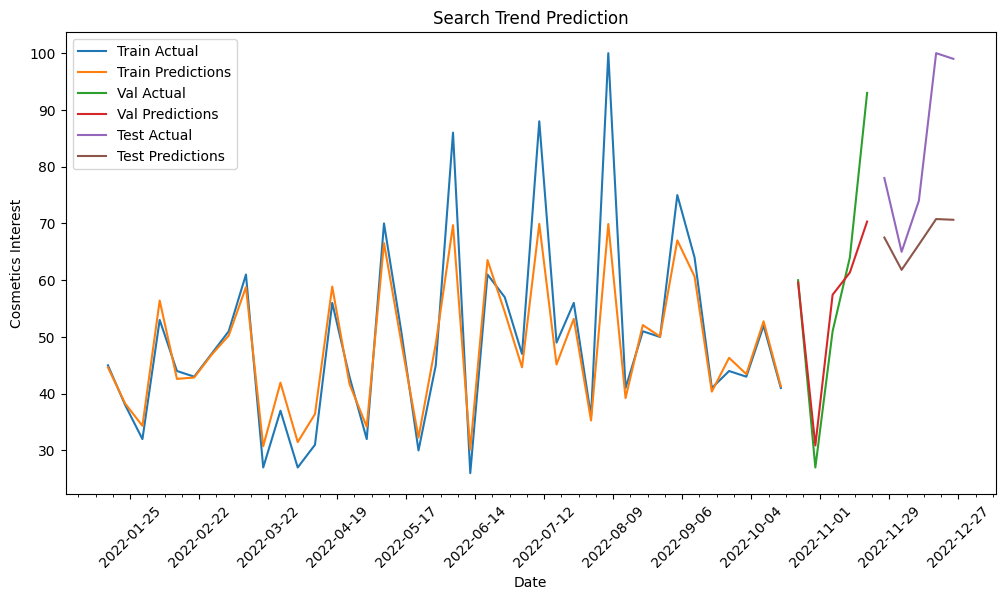

Model saved as 'cosmetics_trend_prediction_model.h5'


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
def main():
    paths = ['/kaggle/input/kpopset/kpop.csv', '/kaggle/input/kpopset/etudehouse.csv',
             '/kaggle/input/kpopset/innisfree.csv', '/kaggle/input/kpopset/laneige.csv',
             '/kaggle/input/koreanfood/kbbq.csv', '/kaggle/input/koreanfood/koreancuisine.csv',
             '/kaggle/input/koreanfood/koreanfood.csv']
    df = load_data(paths)
    df = preprocess_data(df)

    print("Columns after preprocessing:", df.columns)

    windowed_df = create_windowed_df(df, n=3)
    splits = split_data(windowed_df)

    model = build_model()
    train_model(model, splits)
    predict_and_plot(model, splits)

    # Save the trained model
    model.save('/mnt/data/cosmetics_trend_prediction_model.h5')
    print("Model saved as 'cosmetics_trend_prediction_model.h5'")

if __name__ == "__main__":
    main()